# Определение возраста покупателей

## Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;

Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator



In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    seed=12345
)

Found 7591 validated image filenames.


In [3]:
labels.head(15)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


Мы имеем данные состоящие из 7591 строк и двух столбцов. В столбце "file_name" содержится имя файла (фотографии), в столбце "real_age" реальный возраст лица.

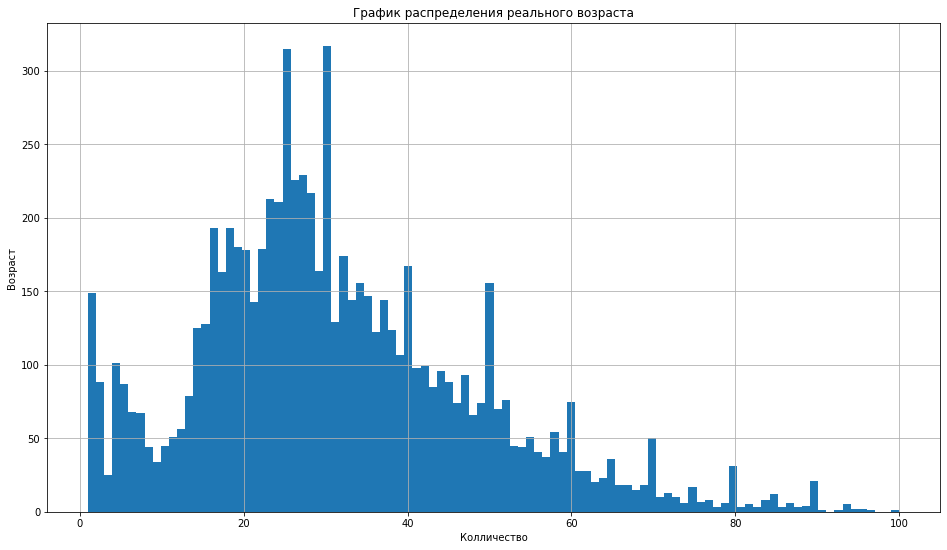

In [4]:
plt.figure(figsize=(16, 9))
plt.title("График распределения реального возраста")
plt.xlabel("Колличество")
plt.ylabel("Возраст")
labels.real_age.hist(bins=100)
plt.show()

Распределение скошено вправо. Мы наблюдаем что большинство возрастов находится в диапазоне от 18 до 30 лет. Причем можно увидеть что имеется некоторый провал в данных в возрасте 10-15 лет.

Напечатаем на экране 15 фотографий, внизу подписи к фотографиям который указывает на возраст лица на фотографии.

In [5]:
sample_images, _ = next(train_gen_flow)

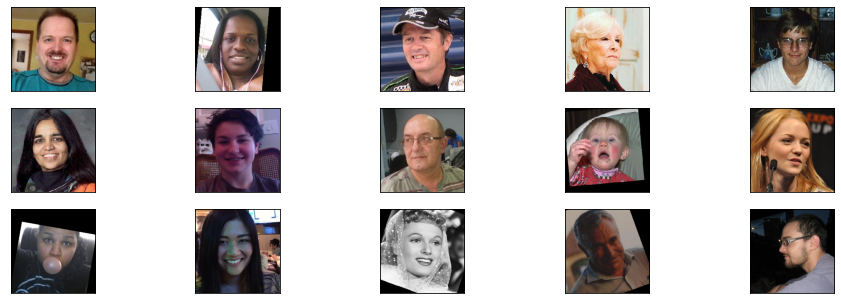

In [6]:
plt.figure(figsize=(16, 9))
for i in range(15):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(sample_images[i], cmap=plt.cm.binary)

Мы видим фотографии людей разных возрастов. встречаются как черно-белые фотографии так и цветные. На фотографиях люди разных возрастов, имеются фотографии людей которые фотографии которых сделаны  как в фас так и в профиль. Есть фотографии на которых часть лица закрыта -   жвачка перед лицом или рука.  

### Вывод

Данные перекошены вправо, следовательно нейросеть будет хорошо определять возраст если лицу будет 15-30 лет. Возраст 10-15 лет определять будет плохо, так как есть некоторый провал в данных.

## Обучение модели

```python

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten, Conv2D
from tensorflow.keras.optimizers import Adam
import PIL as PIL
from PIL import Image

labels = pd.read_csv('/datasets/faces/labels.csv')

def load_train(path):
    datagen = ImageDataGenerator(rescale=1/255., validation_split=0.25)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345
    )
    return train_gen_flow

def load_test(path):
    datagen = ImageDataGenerator(rescale=1/255., validation_split=0.25)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345
    )
    return test_gen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=(150, 150, 3),
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model
    
def train_model(model, train_data, test_data, batch_size=None, epochs=10, steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

```

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 69s - loss: 236.3855 - mae: 10.8789 - val_loss: 778.4877 - val_mae: 22.9750
Epoch 2/10
178/178 - 38s - loss: 60.5789 - mae: 5.8942 - val_loss: 758.7374 - val_mae: 22.6146
Epoch 3/10
178/178 - 38s - loss: 28.7844 - mae: 4.1632 - val_loss: 305.4835 - val_mae: 13.0310
Epoch 4/10
178/178 - 38s - loss: 18.9875 - mae: 3.3633 - val_loss: 124.0712 - val_mae: 8.7072
Epoch 5/10
178/178 - 38s - loss: 14.8503 - mae: 2.9773 - val_loss: 95.6566 - val_mae: 7.4070
Epoch 6/10
178/178 - 39s - loss: 10.7169 - mae: 2.5194 - val_loss: 70.2094 - val_mae: 6.2868
Epoch 7/10
178/178 - 38s - loss: 9.3742 - mae: 2.3196 - val_loss: 67.2902 - val_mae: 6.1976
Epoch 8/10
178/178 - 38s - loss: 8.7543 - mae: 2.2656 - val_loss: 74.1152 - val_mae: 6.4237
Epoch 9/10
178/178 - 38s - loss: 8.1696 - mae: 2.1980 - val_loss: 68.4230 - val_mae: 6.2465
Epoch 10/10
178/178 - 39s - loss: 7.1296 - mae: 2.0239 - val_loss: 65.3979 - val_mae: 6.1749

60/60 - 10s - loss: 65.3979 - mae: 6.1749
Test MAE: 6.1749

```

### Вывод

Модель сверточной нейронной сети построена на ResNet50. Модель обучалась на 10 эпохах.  

## Анализ обученной модели

При обучении модели MAE на валидационной выборке уменьшилось с 22 до 6, вроде бы не плохо, но если мы берем возраст 14 лет то разброс получается большой, так ребенок 12 лет может выглядеть на все 18, как следствие модель с недостаточной эффективностью может контролировать добросовестность кассиров при продаже алкоголя. Мне кажется это вызвано недостаточностью фотографий подростков. Для более корректной работы модели необходимо больше фотографий подростков.